In [1]:
from collections import defaultdict
import os
from os import path as op
from pathlib import Path
import json
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.lib.npyio import load

import seaborn as sns

import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from scipy import stats

import mne
from mne import EvokedArray

# from mne.epochs import concatenate_epochs
from mne.decoding import (
    SlidingEstimator,  # GeneralizingEstimator,
    cross_val_multiscore,
    LinearModel,
    get_coef,
)
from mne.stats import permutation_cluster_1samp_test, f_mway_rm, f_threshold_mway_rm

from vr2fem_analyses.staticinfo import CONFIG, PATHS, COLORS
from vr2fem_analyses import helpers

In [16]:
def load_decod_res_per_viewcond(
    sub_list_str,
    conditions,
    vc_list=[],
    scoring="accuracy",
    picks_str=None,
    gen_str=None,
):
    data_dict = dict()
    if picks_str is not None:
        picks_str_folder = picks_str
    else:
        picks_str_folder = ""

    if gen_str is not None:
        gen_folder = gen_str
    else:
        gen_folder = ""

    if len(vc_list) == 0:
        vc_list = [""]

    paths = PATHS()

    contrast_str = "_vs_".join(conditions)

    for vc in vc_list:
        data_dict[vc] = dict(scores=[], times=[], patterns=[])
        for subID in sub_list_str:
            fpath = Path(
                paths.DATA_04_DECOD_SENSORSPACE,
                vc,
                contrast_str,
                gen_folder,
                scoring,
                picks_str_folder,
                "scores",
            )
            fname = Path(fpath, f"{subID}-scores_per_sub.npy")
            scores_ = np.load(fname)
            data_dict[vc]["scores"].append(scores_)

            if len(data_dict[vc]["times"]) == 0:
                data_dict[vc]["times"] = np.load(str(fname)[:-4] + "__times" + ".npy")
            else:
                assert np.all(
                    data_dict[vc]["times"]
                    == np.load(str(fname)[:-4] + "__times" + ".npy")
                )

            fpath = Path(
                paths.DATA_04_DECOD_SENSORSPACE,
                contrast_str,
                gen_folder,
                scoring,
                picks_str_folder,
                "patterns",
            )
            fname = op.join(fpath, f"{subID}-patterns_per_sub.npy")
            patterns_ = np.load(fname)
            data_dict[vc]["patterns"].append(patterns_)

        data_dict[vc]["scores"] = np.array(data_dict[vc]["scores"])
        data_dict[vc]["patterns"] = np.array(data_dict[vc]["patterns"])

    return data_dict


def load_patterns(
    sub_list_str,
    contrast_str,
    viewcond="",
    scoring="accuracy",
    reg="",
    labels_shuffled=False,
):
    """Load the patterns from sensor space decoding.

    Parameters
    ----------
    sub_list_str : list, str
        List of subject IDs to load patterns from.
    contrast_str : str
        Decoded contrast.
    viewcond : str
        Viewing condition. 'mono', 'stereo', or ''(default) for data pooled across both viewing conditions.
    scoring: str
        Scoring metric used during decoding. "roc_auc", accuracy" (default), or "balanced_accuracy";
    reg: str, float
        Regularization method used; Ints are interpreted as fixed shrinkage values; defaults to an empty string
    labels_shuffled : bool
        Allows to load the data from the run with shuffled labels.


    Returns
    -------
    patterns: ndarray
        Array with the patterns (subs x csp_components x channels x freqs x times)
    times: array, 1d

    """

    paths = PATHS()

    if isinstance(reg, float):
        reg_str = "shrinkage" + str(reg)
    else:
        reg_str = reg
    shuf_labs = "labels_shuffled" if labels_shuffled else ""

    patterns_list = []
    times = []

    for subID in sub_list_str:
        fpath = Path(
            paths.DATA_04_DECOD_SENSORSPACE, viewcond, contrast_str, scoring, "patterns"
        )
        fname = op.join(fpath, f"{subID}-patterns_per_sub.npy")
        patterns_ = np.load(fname)
        patterns_list.append(patterns_)
        if len(times) == 0:
            times = np.load(str(fname)[:-4] + "__times" + ".npy")
        else:
            assert np.all(
                times == np.load(str(fname)[:-4] + "__times" + ".npy")
            ), "Times are different between subjects."

    patterns = np.concatenate(patterns_list)
    return patterns, times


def get_info(return_inst=False):
    paths = PATHS()
    fname = Path(
        paths.DATA_03_AR,
        'cleaneddata',
        f"VR2FEM_S01-postAR-epo.fif",
    )
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)

    if return_inst:
        return epos.info, epos
    else:
        return epos.info


def get_epos(subID):
    paths = PATHS()
    fname = Path(
        paths.DATA_03_AR,
        'cleaneddata',
        f"{subID}-postAR-epo.fif",
    )
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    epos = epos.set_eeg_reference('average', projection=True)
    return epos


def l2norm(vec):
    out = np.sqrt(np.sum(vec**2))
    return out


def run_cbp_test(data, tail=0):
    # number of permutations to run
    n_permutations = 10000
    # set initial threshold
    p_initial = 0.05
    # set family-wise p-value
    p_thresh = 0.05
    connectivity = None
    tail = tail  # 1 or -1 for one-sided test, 0 for two-sided

    config = CONFIG()

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = mne.stats.permutation_cluster_1samp_test(
        data,
        threshold=threshold,
        n_jobs=config.N_JOBS,
        verbose=False,
        tail=tail,
        step_down_p=0.0005,
        adjacency=connectivity,
        n_permutations=n_permutations,
        seed=42,
        out_type="mask",
    )

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return T_obs, clusters, cluster_p_values


def plot_score_per_factor(
    factor,
    data,
    scoring="accuracy",
    sign_clusters=[],
    p_lvl=0.05,
    chancelvl=0.5,
    ylims=None,
    xlims=None,
    ax=None,
    n_boot=1000,
):

    colors = COLORS()

    sns.lineplot(
        x="time",
        y="score",
        hue=factor,
        data=data,
        n_boot=n_boot,
        palette=colors.COLDICT,
        ax=ax,
        linewidth=0.5,
        legend=False,
        errorbar="se",
    )
    ytick_range = ax.get_ylim()
    if ylims is None:
        ylims = ytick_range
    ax.set(xlim=xlims, ylim=ylims)
    if scoring == "roc_auc":
        scoring_str = "ROC AUC"
    else:
        scoring_str = scoring
    ax.set_ylabel(scoring_str)
    ax.set_xlabel("Time (s)")

    ax.text(x=1.0, y=chancelvl + 0.001, s='chance', ha='right')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.vlines(
        (0),
        ymin=ylims[0],
        ymax=ylims[1],
        linestyles="dashed",
        linewidth=0.5,
        color="black",
    )
    ax.hlines(
        chancelvl,
        xmin=xlims[0],
        xmax=xlims[1],
        linewidth=0.5,
        color="black",
    )
    p_lvl_str = "$p$ < ." + str(p_lvl).split(".")[-1]
    if isinstance(sign_clusters, dict):
        for i, key in enumerate(sign_clusters):
            col = colors.COLDICT[key.lower()]
            for sc in sign_clusters[key.lower()]:
                xmin = sc[0]
                xmax = sc[-1]
                y_ = ylims[0] + (0.01 - ((i + 1) * 0.025) * np.ptp(ylims))
                ax.hlines(
                    y_,
                    xmin=xmin,
                    xmax=xmax,
                    color=col,
                    label=p_lvl_str,
                )
            if i==0:
                ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha='right')

    else:
        for sc in sign_clusters:
            xmin = sc[0]
            xmax = sc[-1]
            y_ = ytick_range[0] + 0.05 * np.ptp(ytick_range)
            ax.hlines(
                y_,
                xmin=xmin,
                xmax=xmax,
                color="purple",
                label=p_lvl_str,
            )
        if len(sign_clusters) > 0:
            ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha='right')

    handles, labels = ax.get_legend_handles_labels()
    n_sgn_clu = None if len(sign_clusters) <= 1 else -(len(sign_clusters))
    # ax.legend(handles=handles[1:n_sgn_clu+1], labels=labels[1:n_sgn_clu+1])


def prep_and_plot_from_data(data_dict, subsets, ax, chancelvl=0.25, ylims=(0.2, 0.32)):
    # Prepare data for plotting with seaborn:
    results_df_list = list()
    for vc in subsets:
        times = data_dict[vc]["times"]
        acc = np.asarray(data_dict[vc]["scores"])
        acc_df = pd.DataFrame(acc)
        acc_df.columns = times
        df = acc_df.melt(var_name="time", value_name="score")  # put into long format
        df["vc"] = vc
        results_df_list.append(df)
    data_plot = pd.concat(results_df_list)

    sign_cluster_times = {}
    # run CBP to find differences from chance:
    for vc in subsets:
        data = np.asarray(data_dict[vc]["scores"]) - chancelvl
        t_values, clusters, p_values = run_cbp_test(data, tail=1)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times[vc] = [
            times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters
        ]

    if len(subsets) == 2:
        # run CBP to find difference between conditions:
        data = np.asarray(data_dict[subsets[0]]["scores"]) - np.asarray(
            data_dict[subsets[1]]["scores"]
        )
        t_values, clusters, p_values = run_cbp_test(data, tail=0)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times["diff"] = [
            times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters
        ]
        if len(sign_cluster_times["diff"]) > 0:
            helpers.print_msg(
                "Found significant difference between conditions! Do you see that?"
            )

    # Plot it:

    plot_score_per_factor(
        factor="vc",
        data=data_plot.reset_index(),
        scoring="Accuracy",
        sign_clusters={ecc: sign_cluster_times[ecc] for ecc in subsets},
        p_lvl=p_val_cbp,
        chancelvl=chancelvl,
        ylims=ylims,
        xlims=(-0.2, 1.0),
        n_boot=10000,
        ax=ax,
    )

In [8]:
# Setup:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams.update({'font.size': 16})
cm = 1 / 2.54

# plotting:

p_val_cbp = 0.05

paths = PATHS()
path_in = Path(paths.DATA_03_AR, "cleaneddata")

# load data
sub_list_str = [s.split("-postAR-epo")[0] for s in os.listdir(path_in)]

## Multiclass decoding "emotion"

First pooled across the two viewing conditions:

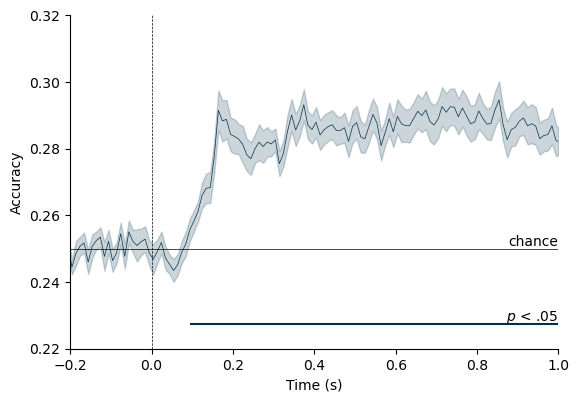

In [4]:
data_dict_allemos = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["neutral", "angry", "happy", "surprised"],
    vc_list=["", "mono", "stereo"],
)
data_dict_allemos["all"] = data_dict_allemos.pop("")

fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict_allemos, subsets=["all"], ax=ax, chancelvl=0.25, ylims=(0.22, 0.32)
)



Now per viewing condition:

/u/fklotzsche/conda-envs/vr2fem/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


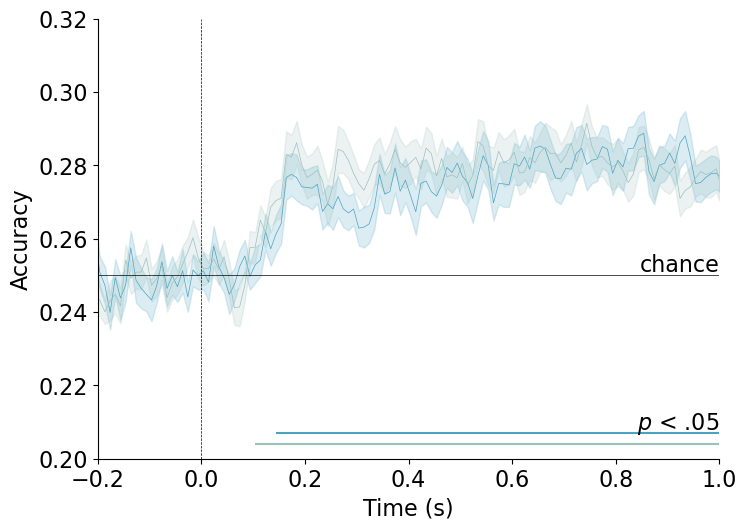

In [17]:

fig, ax = plt.subplots(1, 1, figsize=(18.8 * cm, 13.3 * cm))

prep_and_plot_from_data(
    data_dict=data_dict_allemos,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.25,
    ylims=(0.2, 0.32),
)

fig.tight_layout()
fig.subplots_adjust(left=0.08, bottom=0.08, right=0.92, top=0.92)

fig.savefig(
    Path(paths.FIGURES, f"decod_emo-all_mono-vs-stereo.pdf"), transparent=True, #bbox_inches="tight"
)

## Decoding the viewing condition
Now we see whether we can decode (across all emotions) whether we can decode in which `viewing condition` a trial was shown.

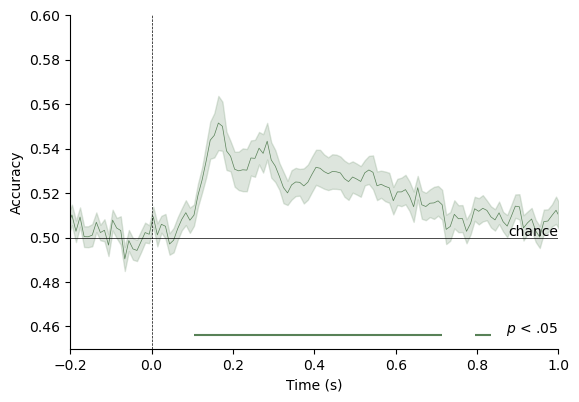

In [27]:
data_dict_vc = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["mono", "stereo"],
    vc_list=[""],
)
data_dict_vc["viewcond"] = data_dict_vc.pop("")

fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_vc,
    subsets=["viewcond"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
)

## Binary Contrasts
Now we look into decoding binary comparisons of emotions.

### 1. Angry vs neutral

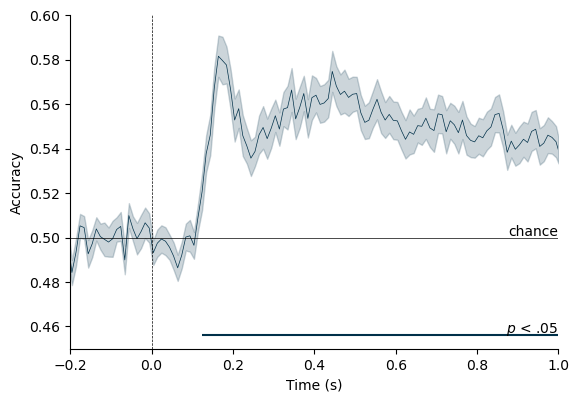

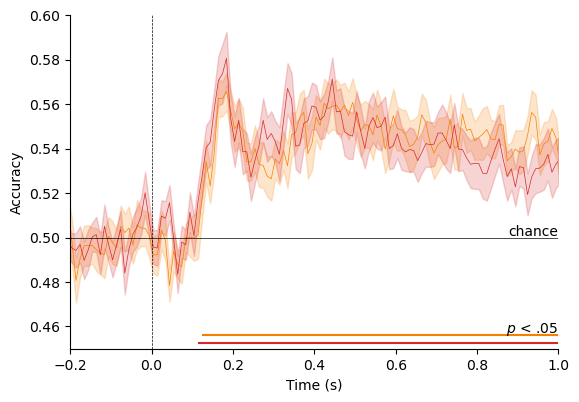

In [28]:
## Contrast: angry-neutral

data_dict_na = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["neutral", "angry"],
    vc_list=["", "mono", "stereo"],
)
data_dict_na["all"] = data_dict_na.pop("")

fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict_na, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6)
)


fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_na,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
)

### 2. Surprised vs angry

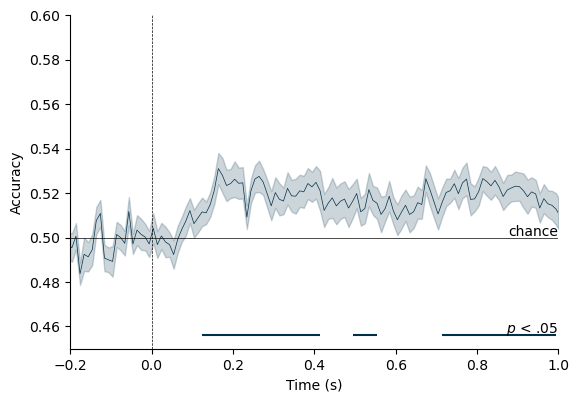

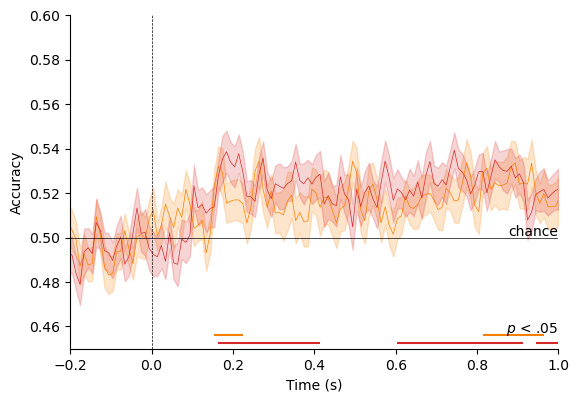

In [29]:
## Contrast: sursprised-angry

data_dict_na = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["surprised", "angry"],
    vc_list=["", "mono", "stereo"],
)
data_dict_na["all"] = data_dict_na.pop("")

fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict_na, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6)
)


fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_na,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
)


#####################################################################################
Found significant difference between conditions! Do you see that?
#####################################################################################



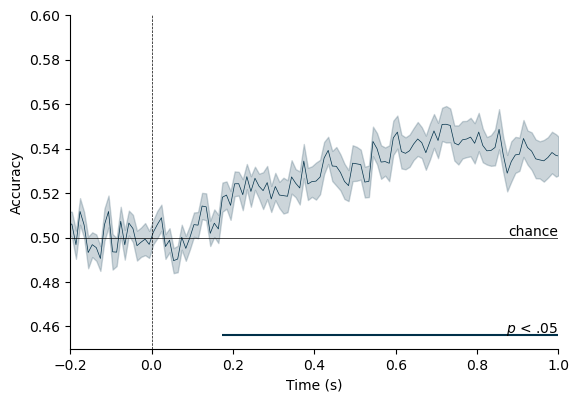

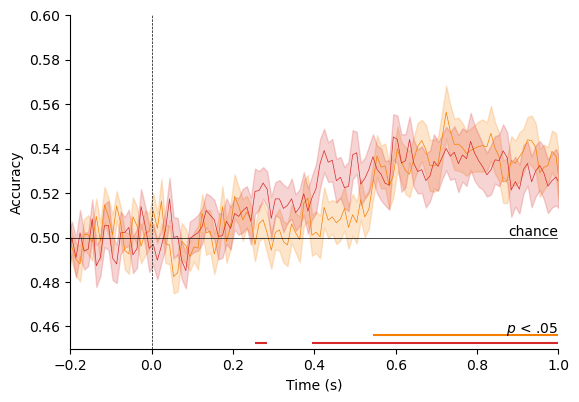

In [30]:
## Contrast: happy vs neutral

data_dict_hn = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["happy", "neutral"],
    vc_list=["", "mono", "stereo"],
)
data_dict_hn["all"] = data_dict_hn.pop("")

fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict_hn, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.45, 0.6)
)


fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_hn,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.6),
)

## (Implicit) Decoding Identity

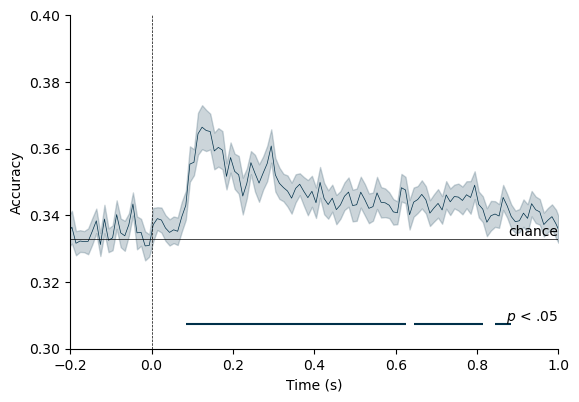

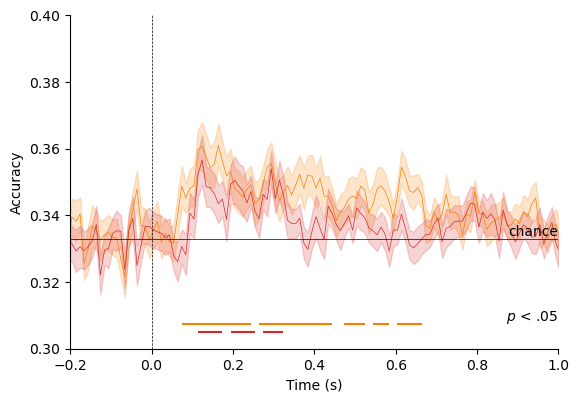

In [39]:
data_dict_id = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["id1", "id2", "id3"],
    vc_list=["", "mono", "stereo"],
)
data_dict_id["all"] = data_dict_id.pop("")

fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict_id, subsets=["all"], ax=ax, chancelvl=0.333, ylims=(0.3, 0.4)
)


fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict=data_dict_id,
    subsets=["stereo", "mono"],
    ax=ax,
    chancelvl=0.333,
    ylims=(0.3, 0.4),
)

In [8]:
sub_patterns, pat_times = load_patterns(
    sub_list_str,
    contrast_str='neutral_vs_angry',
    viewcond="",
    scoring="accuracy",
    reg="",
    labels_shuffled=False,
)

sub_patterns_norm = np.zeros_like(sub_patterns)
# normalize them by L2 norm to allow for unbiased averages:
for sub in range(sub_patterns.shape[0]):
    for time in range(sub_patterns.shape[-1]):
        sub_patterns_norm[sub, :, time] = sub_patterns[sub, :, time] / l2norm(
            sub_patterns[sub, :, time]
        )
sub_patterns_avg = sub_patterns_norm.copy().mean(axis=0)
sub_patterns_avg_norm = np.stack(
    [
        sub_patterns_avg[:, ii] / l2norm(sub_patterns_avg[:, ii])
        for ii in range(sub_patterns_avg.shape[-1])
    ],
    axis=-1,
)

# Build new pseudo Evoke obj:
dummy_epos_info = get_info()
easycap_montage = mne.channels.make_standard_montage("easycap-M1")
info = mne.create_info(ch_names=dummy_epos_info.ch_names, sfreq=(1 / np.median(np.diff(pat_times))), ch_types="eeg")
info.set_montage(easycap_montage)
sub_patterns_evo = EvokedArray(sub_patterns_avg_norm, info, tmin=pat_times[0])


In [9]:
times_plot = [0.0, 0.2, 0.4, 0.6, 0.8]

fig, ax = plt.subplots(3,3, figsize=(16.6*cm,15*cm), gridspec_kw={'width_ratios': [10, 10, 1]})

aaxx = [[0,0], [0,1], [1,0], [1,1], [2,0]]

for tt, axi in zip(times_plot, aaxx):
    #axii = fig.add_subplot(axi)
    t_plot = [tt]
    plt_load = sub_patterns_evo.plot_topomap(times = t_plot, 
                                    scalings=1, 
                                    units='',
                                    title='',  # f"{ecc_cond} -- Decod. Target: {config.labels['Load']}",
                                    cmap = 'RdBu_r',
                                    vmin = -0.3,
                                    vmax=0.3,
                                    contours=10,
                                    ch_type='eeg',
                                    extrapolate='local',
                                    axes=[ax[axi[0], axi[1]], ax[2,2]],
                                    show=False)
    ax[axi[0], axi[1]].set_title('')
# cb = ax.figure.colorbar(plt_load, ax=ax_cb)
fig.delaxes(ax[0][2])
fig.delaxes(ax[1][2])
fig.delaxes(ax[2][1])
plt.show()

In [10]:
import mne.minimum_norm as minnorm
from mne.datasets import fetch_fsaverage

In [11]:
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = Path(fs_dir).parent
subject = 'fsaverage'

0 files missing from root.txt in /u/fklotzsche/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage


In [12]:
src = mne.setup_source_space(
    subject, spacing="oct6", subjects_dir=subjects_dir, add_dist=False
)
src.save(
    Path(fs_dir, "bem", subject + "-oct6" + "-src.fif"), overwrite=True
)

Setting up the source space with the following parameters:

SUBJECTS_DIR = /u/fklotzsche/mne_data/MNE-fsaverage-data
Subject      = fsaverage
Surface      = white
Octahedron subdivision grade 6

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.white...
Mapping lh fsaverage -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 4098/163842 selected to source space (oct = 6)

Loading /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.white...
Mapping rh fsaverage -> oct (6) ...
    Triangle neighbors and vertex normals...
Loading geometry from /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/surf/rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 4098/163842 selected to source sp

In [13]:
paths.src = Path(fs_dir, "bem", subject + "-oct6" + "-src.fif")
paths.src_trans = Path(fs_dir, 'bem', subject + '-trans.fif')
paths.src_bemsol = Path(fs_dir, 'bem', subject + '-5120-5120-5120-bem-sol.fif')
config = CONFIG()

fwd = mne.make_forward_solution(info, trans=paths.src_trans, src=paths.src,
                                bem=paths.src_bemsol, eeg=True, mindist=5.0, n_jobs=config.N_JOBS)
paths.src_fwd = Path(fs_dir, 'bem', subject + '-oct6' + '-fwd.fif')
mne.write_forward_solution(paths.src_fwd, fwd, overwrite=True, verbose=None)

Source space          : /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-oct6-src.fif
MRI -> head transform : /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-trans.fif
Measurement data      : instance of Info
Conductor model   : /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-5120-5120-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /u/fklotzsche/mne_data/MNE-fsaverage-data/fsaverage/bem/fsaverage-oct6-src.fif...
Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999994  0.003552  0.000202      -1.76 mm
    -0.003558  0.998389  0.056626      31.09 mm
    -0.000001 -0.056626  0.998395      39.60 mm
     0.000000  0.000000  0.000000       1.00

Read  60 EEG channels from info
Head coordinate coil definitions created.
Source spaces are now in head coordinates.

Setting up the BEM model using /u/fklotz

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  15 tasks      | elapsed:    0.1s


    Found    0/3099 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 465.3 ms
Checking surface interior status for 4098 points...
    Found  906/4098 points inside  an interior sphere of radius   47.7 mm
    Found    0/4098 points outside an exterior sphere of radius   98.3 mm
    Found    0/3192 points outside using surface Qhull


[Parallel(n_jobs=-2)]: Done 143 out of 143 | elapsed:    0.5s finished
[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  15 tasks      | elapsed:    0.1s


    Found    0/3192 points outside using solid angles
    Total 4098/4098 points inside the surface
Interior check completed in 471.6 ms

Setting up for EEG...


[Parallel(n_jobs=-2)]: Done 143 out of 143 | elapsed:    0.5s finished


Computing EEG at 8196 source locations (free orientations)...


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  15 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-2)]: Done 123 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-2)]: Done 143 out of 143 | elapsed:    3.8s finished



Finished.
Overwriting existing file.
    Write a source space...
    [done]
    Write a source space...
    [done]
    2 source spaces written


In [ ]:
stcs = []

for i in range(len(sub_list_str)-30):
    # Calc cov:
    epos = get_epos(sub_list_str[i])
    noise_cov = mne.compute_covariance(epos, tmax=0)
    # Build new pseudo Evoke obj so we can adapt sfreq:
    easycap_montage = mne.channels.make_standard_montage("easycap-M1")
    info = mne.create_info(ch_names=epos.ch_names, sfreq=1 / np.median(np.diff(pat_times)), ch_types="eeg")
    info.set_montage(easycap_montage)
    sub_pattern_src = EvokedArray(sub_patterns[i], info, tmin=pat_times[0])
    inst = sub_pattern_src.set_eeg_reference('average', projection=True) 
    inst.data = sub_patterns[i]
    inv_op = mne.minimum_norm.make_inverse_operator(
        info, fwd, noise_cov, fixed=False,
        loose=0.2,
        depth=0.8  # ignored by eLoreta
    )

    # mne.minimum_norm.write_inverse_operator(inv_op_dir, inv_op)
    stc = abs(mne.minimum_norm.apply_inverse(
        inst, inv_op, 0.1, "eLORETA", verbose=True)) #, method_params=dict(eps=1e-4)
    #))
    stcs.append(stc)


In [ ]:
dd3 = np.array([st.data for st in stcs])


In [ ]:

dd3_norm = np.zeros_like(dd3)
for sub in range(dd3.shape[0]):
    for time in range(dd3.shape[-1]):
        dd3_norm[sub, :, time] = dd3[sub, :, time] / l2norm(
            dd3[sub, :, time]
        )


In [3]:

stc_mean3 = np.mean(dd3_norm, axis=0)
stc_dummy = stcs[0]
stc_dummy.data = stc_mean3

NameError: name 'dd3_norm' is not defined

Using notebook 3d backend.

Using control points [0.01766127 0.0189808  0.02848566]


2022-11-03 15:12:02.680 (   0.510s) [        89B76740]   vtkShaderProgram.cxx:452    ERR| vtkShaderProgram (0x556f3a2ab1d0): 1: 
2:   #version 140
3: #ifdef GL_ES
4: #ifdef GL_FRAGMENT_PRECISION_HIGH
5: precision highp float;
6: precision highp sampler2D;
7: precision highp sampler3D;
8: #else
9: precision mediump float;
10: precision mediump sampler2D;
11: precision mediump sampler3D;
12: #endif
13: #define texelFetchBuffer texelFetch
14: #define texture1D texture
15: #define texture2D texture
16: #define texture3D texture
17: #else // GL_ES
18: #define highp
19: #define mediump
20: #define lowp
21: #if __VERSION__ == 150
22: #define texelFetchBuffer texelFetch
23: #define texture1D texture
24: #define texture2D texture
25: #define texture3D texture
26: #endif
27: #endif // GL_ES
28: #define varying in
29: 
30:   in vec2 texCoord;
31:   uniform sampler2DMS tex;
32:   uniform int samplecount;
33:   out vec4 fragOutput0;
34: 
35: 
36:   void main()
37:   {
38:     float gamma =ERROR:roo

2022-11-03 15:12:04.481 (   2.311s) [        89B76740]   vtkShaderProgram.cxx:452    ERR| vtkShaderProgram (0x556f3eeb78e0): 1: #version 140
2: #ifdef GL_ES
3: #ifdef GL_FRAGMENT_PRECISION_HIGH
4: precision highp float;
5: precision highp sampler2D;
6: precision highp sampler3D;
7: #else
8: precision mediump float;
9: precision mediump sampler2D;
10: precision mediump sampler3D;
11: #endif
12: #define texelFetchBuffer texelFetch
13: #define texture1D texture
14: #define texture2D texture
15: #define texture3D texture
16: #else // GL_ES
17: #define highp
18: #define mediump
19: #define lowp
20: #if __VERSION__ == 150
21: #define texelFetchBuffer texelFetch
22: #define texture1D texture
23: #define texture2D texture
24: #define texture3D texture
25: #endif
26: #endif // GL_ES
27: #define varying in
28: 
29: 
30: /*=========================================================================
31: 
32:   Program:   Visualization Toolkit
33:   Module:    vtkPolyData2DFS.glsl
34: 
35:   ERROR:roo

2022-11-03 15:12:08.896 (   6.726s) [        89B76740]   vtkShaderProgram.cxx:437    ERR| vtkShaderProgram (0x556f3eeb78e0): 1: #version 140
2: #ifndef GL_ES
3: #define highp
4: #define mediump
5: #define lowp
6: #endif // GL_ES
7: #define attribute in
8: #define varying out
9: 
10: 
11: /*=========================================================================
12: 
13:   Program:   Visualization Toolkit
14:   Module:    vtkPolyData2DVS.glsl
15: 
16:   Copyright (c) Ken Martin, Will Schroeder, Bill Lorensen
17:   All rights reserved.
18:   See Copyright.txt or http://www.kitware.com/Copyright.htm for details.
19: 
20:      This software is distributed WITHOUT ANY WARRANTY; without even
21:      the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR
22:      PURPOSE.  See the above copyright notice for more information.
23: 
24: =========================================================================*/
25: 
26: // all variables that represent positions or directions have 

<IPython.core.display.Javascript object>


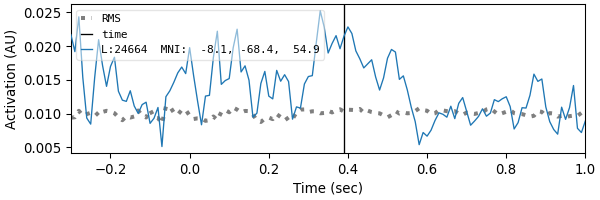

In [20]:
%matplotlib qt
kwargs = dict(initial_time=0.4, hemi='lh', subjects_dir=subjects_dir,
              size=(600, 600),  # clim={'lims':(50, 75, 95), 'kind': 'percent'},  # (0, 10, 20)},
              colormap='hot',  
              # transparent=False,
              background='white',
              smoothing_steps=7,
              backend='notebook',
              views='ven')
stc_dummy.plot(**kwargs)

In [19]:
epos.plot()

Using qt as 2D backend.


Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none
